<a href="https://colab.research.google.com/github/auliyaf/Patech/blob/main/%5B3_Variable%5D_Patech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sklearn
from sklearn.model_selection import train_test_split

In [9]:
url = 'https://raw.githubusercontent.com/auliyaf/Patech/main/DatasetPatechClean.csv'
df = pd.read_csv(url)

indexNames = df[ df['AnthracnoseRisk'] == "None" ].index
df.drop(indexNames , inplace=True)

In [10]:
df.head()

,DurationHrs,AvgTempF,Rainfallin,AnthracnoseRisk
0,71.2,54.6,1.92,High
1,61.8,43.8,0.81,High
2,52.3,48.4,2.60,High
3,59.3,53.4,1.98,High
4,74.0,55.8,0.66,High


In [11]:
#Ambil nilai x dan y
x = df.iloc[:, [0, 1,2]]
y = df.iloc[:, [3]]

#Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [12]:
class KNN():
    def __init__ (self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    #Weighted KNN
    def predict_ecluidean_w(self, x_test, k=3):
        # default k = 3
        self.pred = []
        count = 0
        for i in x_test.index:
            data = self.x_train.loc[:, ["DurationHrs", "AvgTempF", "Rainfallin"]] - x_test.loc[i, ["DurationHrs", "AvgTempF","Rainfallin"]]
            data["sum"] = np.sqrt(data["DurationHrs"] ** 2 + data["AvgTempF"] ** 2 + data["Rainfallin"]**2 )
            data["ur"] = self.y_train["AnthracnoseRisk"]
            data["weight"] = 1/data["sum"]
            urPred = data.sort_values(by=["sum"]).head(n=k).groupby("ur")["weight"].sum()
            self.pred.append(urPred.idxmax())
        
        self.pred = pd.DataFrame(self.pred, columns=["prediction"], index=x_test.index)

    #Confussion Matrix
    def confussion_mx(self, y_test):
        self.df_actual = pd.DataFrame()
        self.df_actual["actual"] = y_test["AnthracnoseRisk"]
        self.df_actual["predicted"] = self.pred["prediction"]

        act_h = self.df_actual["actual"] == "High"
        act_m = self.df_actual["actual"] == "Moderate"
        act_l = self.df_actual["actual"] == "Low"

        pred_h = self.df_actual["predicted"] == "High"
        pred_m = self.df_actual["predicted"] == "Moderate"
        pred_l = self.df_actual["predicted"] == "Low"

        ah_ph = len(self.df_actual[act_h & pred_h])
        ah_pm = len(self.df_actual[act_h & pred_m])
        ah_pl = len(self.df_actual[act_h & pred_l])

        am_ph = len(self.df_actual[act_m & pred_h])
        am_pm = len(self.df_actual[act_m & pred_m])
        am_pl = len(self.df_actual[act_m & pred_l])

        al_ph = len(self.df_actual[act_l & pred_h])
        al_pm = len(self.df_actual[act_l & pred_m])
        al_pl = len(self.df_actual[act_l & pred_l])

        self.confusion_mx = np.array([[ah_ph, ah_pm, ah_pl], [am_ph, am_pm, am_pl], [al_ph, al_pm, al_pl] ])
        return self.confusion_mx

    #Heatmap
    def toHeatmap(self, mx):
        df_conf_mx = pd.DataFrame(mx, index=["High", "Moderate", "Low"], columns=["High", "Moderate", "Low"])
        print(df_conf_mx)
        plt.figure(figsize=(6, 8))
        sns.set(font_scale = 1)
        sns.heatmap(mx, annot=True, cbar_kws={"orientation": "horizontal"}, xticklabels=["High", "Moderate", "Low"], yticklabels=["High", "Moderate", "Low"], fmt=".1f")
        plt.xlabel("Actual")
        plt.ylabel("Prediction")
        plt.show()
    
    #Precission recall F1-score
    def precission(TP, FP):
        return TP / (TP + FP)

    def recall(TP, FN):
        return TP / (TP + FN)

    def f1_score(recall, precission):
        return (2 * recall * precission) / (recall + precission)

    def getF1(self):
        show = []

        h_tp = self.confusion_mx[0, 0]
        h_tn = self.confusion_mx[1, 1] + self.confusion_mx[1, 2] + self.confusion_mx[2, 1] + self.confusion_mx[2, 2] 
        h_fp = self.confusion_mx[0, 1] + self.confusion_mx[0, 2]
        h_fn = self.confusion_mx[1, 0] + self.confusion_mx[2, 0]

        m_tp = self.confusion_mx[1, 1]
        m_tn = self.confusion_mx[0, 0] + self.confusion_mx[2, 0] + self.confusion_mx[0, 2] + self.confusion_mx[2, 2] 
        m_fp = self.confusion_mx[1, 0] + self.confusion_mx[1, 2]
        m_fn = self.confusion_mx[0, 1] + self.confusion_mx[2, 1]

        l_tp = self.confusion_mx[2, 2]
        l_tn = self.confusion_mx[0, 0] + self.confusion_mx[0, 1] + self.confusion_mx[1, 0] + self.confusion_mx[1, 1] 
        l_fp = self.confusion_mx[2, 0] + self.confusion_mx[2, 1]
        l_fn = self.confusion_mx[0, 2] + self.confusion_mx[1, 2]

        f1_score_full = (h_tp + m_tp + l_tp) / ( (h_tp + m_tp + l_tp) + ((h_fp + m_fp + l_fp) + (h_fn + m_fn + l_fn)) / 2 )
        return f1_score_full

          High  Moderate  Low
High         2         2    0
Moderate     0         4    2
Low          0         2   15


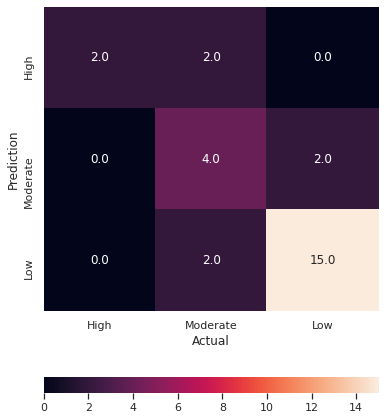

In [13]:
#Weighted KNN
model_ecluidean_w = KNN(x_train, y_train)
model_ecluidean_w.predict_ecluidean_w(x_test, k = 5)
confussion_matrix = model_ecluidean_w.confussion_mx(y_test)
model_ecluidean_w.toHeatmap(confussion_matrix)

In [14]:
ecluidean_w_f1 = model_ecluidean_w.getF1()
ecluidean_w_f1 

0.7777777777777778